In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.optimize import fmin_slsqp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from time import time
import os
import sys
from pathlib import Path
ROOT_PATH = Path().absolute().parent
if str(ROOT_PATH) not in sys.path:
    sys.path.insert(1, str(ROOT_PATH))
from frequency_response import FrequencyResponse
from biquad import peaking, digital_coeffs

In [53]:
fr = FrequencyResponse.read_from_csv(ROOT_PATH.joinpath('results', 'oratory1990', 'harman_over-ear_2018', 'Audeze LCD-4', 'Audeze LCD-4.csv'))

In [17]:
def compare(fp, n):
    fr = FrequencyResponse.read_from_csv(fp)
    old_fbeq = fr.fixed_band_eq.copy()
    old_peq = fr.parametric_eq.copy()
    
    t = time()
    #fr.optimize_parametric_eq(max_filters=n)
    #fr.optimize_fixed_band_eq([31.25, 62.5, 125, 250, 500, 1000, 2000, 4000, 8000, 16000], [1.41] * 10, fs=48000)
    #fr.parametric_eq = fr.fixed_band_eq.copy()
    old_time = time() - t

    t = time()
    filters, n_filters, max_gains = fr.optimize_parametric_eq(n, fs=48000)
    #filters, n_filters, max_gain = fr.optimize_fixed_band_eq([31.25, 62.5, 125, 250, 500, 1000, 2000, 4000, 8000, 16000], 1.41, fs=48000)
    #fr.fixed_band_eq = fr.parametric_eq.copy()
    new_time = time() - t
    
    #fr.parametric_eq = old_peq

    ix = np.sum(fr.frequency < 10e3)
    new_rmse = np.sqrt(np.mean(np.square(fr.equalization[:ix] - fr.parametric_eq[:ix])))
    old_rmse = np.sqrt(np.mean(np.square(fr.equalization[:ix] - old_peq[:ix])))
    print(f'{fr.name}: RMSE {old_rmse:.2f} -> {new_rmse:.2f}  = {"+" if new_rmse > old_rmse else ""}{new_rmse - old_rmse:.2f} dB ({(new_rmse - old_rmse) / old_rmse * 100:.1f} %) @ {old_time*1000:.0f} -> {new_time*1000:.0f} ms')
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(26, 8)
    FrequencyResponse.init_plot(fig=fig, ax=axs[1])
    fr.plot_graph(fig=fig, ax=axs[0], fixed_band_eq_plot_kwargs={'label': 'New optimizer'}, show=False)
    for fc, q, gain in filters:
        axs[1].plot(fr.frequency, digital_coeffs(fr.frequency, 48e3, *peaking(fc, q, gain, fs=48e3), reduce=True), label=f'{fc:.0f} Hz, {q:.3f} Q, {gain:.1f} dB')
    axs[1].legend()
    axs[1].set_title('Filters')
    plt.show()

In [ ]:
n = [5, 5]
i = 1
for fp in ROOT_PATH.joinpath('results', 'oratory1990').glob('*/*/*.csv'):
    compare(fp, n)
    i += 1
    if i > 10:
        break

## Parametric Equalizer Filter Q Regularization
Finding a polynomial function which expresses the maximum gain for a parametric filter with given Q

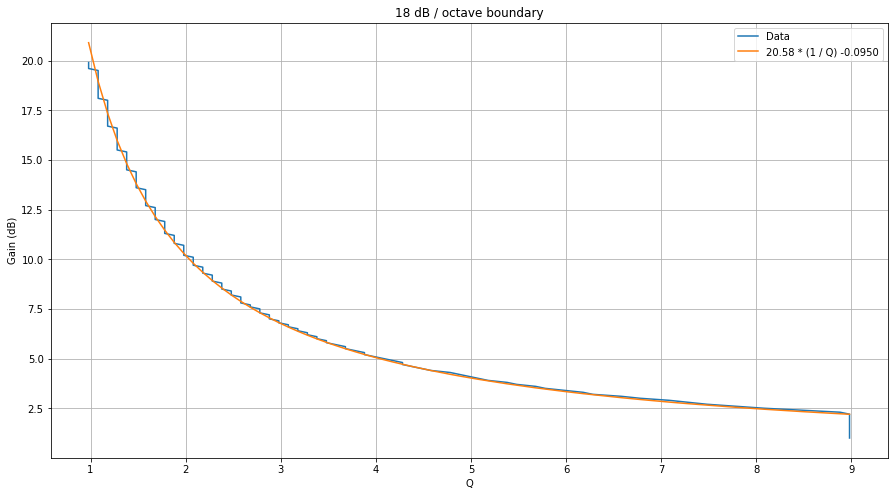

-0.09503189270199464 + 20.575128011847003 x**1


In [440]:
fc = 20 * 2**(np.log(20e3 / 20) / np.log(2) / 2)
q = np.arange(0.18, 9, 0.1)
gain = np.arange(1, 20, 0.1)
f = FrequencyResponse.generate_frequencies()
f_step = np.log(f[1] / f[0]) / np.log(2)
max_d = []
for g in gain:
    frs = digital_coeffs(fr.frequency, 48e3, *peaking(fc, q, g, fs=48000))
    max_d.append([(np.max(fr[1:-1] - np.roll(fr, 1)[1:-1]) / f_step) for fr in frs])
max_d = np.array(max_d)
q, gain = np.meshgrid(q, gain)

d_threshold = 18
qs = []
for row in max_d:
    ix = min(np.sum(row < d_threshold), max_d.shape[1] - 1)
    qs.append(q[0, ix])
qs = np.array(qs)
    
ix0 = np.sum(qs == 9.0)
p = np.polynomial.Polynomial.fit(1 / qs[ix0:], gain[ix0:, 0], 1)
p = p.convert()
est = p(1 / qs[ix0:])
    
fig, ax = plt.subplots()
fig.set_size_inches(15, 8)
ax.plot(qs[ix0:], gain[ix0:, 0], label='Data')
ax.plot(qs[ix0:], est, label=f'{p.coef[1]:.2f} * (1 / Q) {"+" if p.coef[0] >= 0 else "-"}{np.abs(p.coef[0]):.4f}')
ax.grid()
ax.set_ylabel('Gain (dB)')
ax.set_xlabel('Q')
ax.legend()
ax.set_title(f'{d_threshold} dB / octave boundary')
plt.show()
print(p)

## Parametric Equalizer Band Reqularization
Penalizing for filters whos transition bands extend Nyquist frequency

AOC ratio until Nyquist = 0.85
0.79


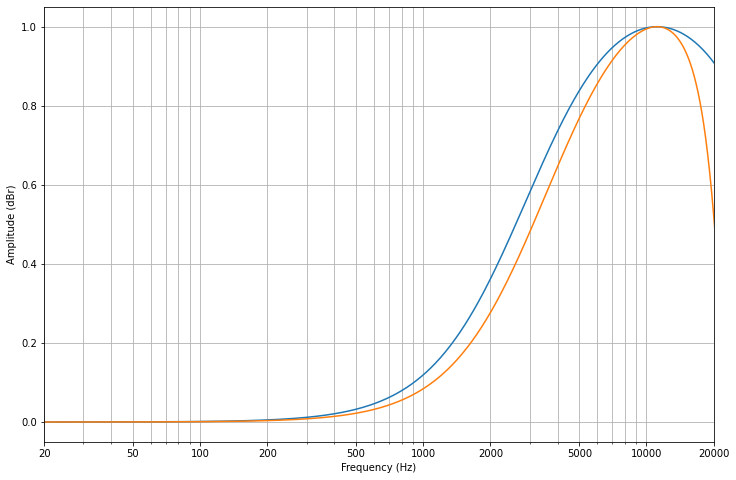

In [64]:
fs = 48e3
f = FrequencyResponse.generate_frequencies(f_max=192e3)
fc = 11153
q = 0.243
bw = q2bw(q)
fr_ref = digital_coeffs(f, 192e3, *peaking(fc, q, 1, fs=192e3))
fr_corrupted = digital_coeffs(f, 48e3, *peaking(fc, q, 1, fs=fs))
f_step = np.log2(f[1] / f[0])
ix = np.argmin(np.abs(fs / 2 - f))
print(f'AOC ratio until Nyquist = {np.sum(fr_corrupted[:ix]) / np.sum(fr_ref[:ix]):.2f}')

f_insp = fc / (2**(bw / 2))
ix_insp = np.argmin(np.abs(f_insp - f))
print(f'{fr_corrupted[ix_insp] / 0.5:.2f}')

fig, ax = FrequencyResponse.init_plot()
ax.plot(f, fr_ref, label='Reference')
ax.plot(f, fr_corrupted, label='True')
#ax.set_xlim([20, fs / 2])
plt.show()

In [557]:
ix_max = np.argmin(np.abs(fr_corrupted - np.max(fr_corrupted)))
ix = np.argmin(np.abs(fr_corrupted[:ix_max] - np.max(fr_corrupted) / 2))
print(f[ix], fr_corrupted[ix], '/', fr_ref[ix], '=', fr_corrupted[ix] / fr_ref[ix])

5752.964286311504 0.4961516832741162 / 0.5908064997220066 = 0.8397871105134616


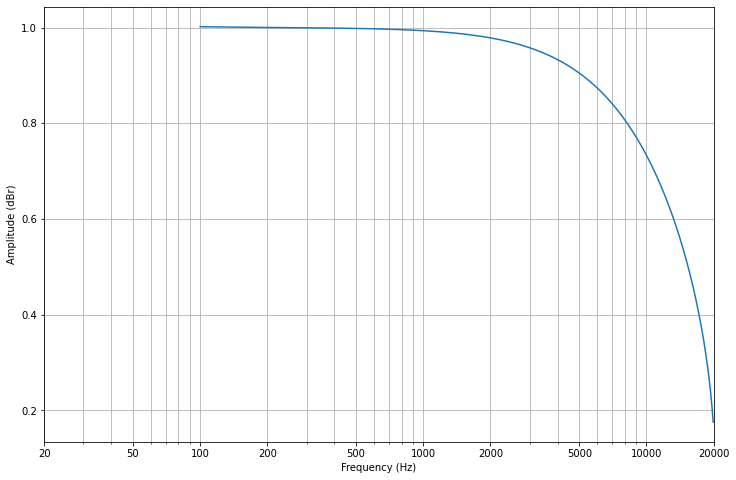

In [6]:
fs = 44.1e3
f = FrequencyResponse.generate_frequencies(f_max=192e3)
f_step = np.log2(f[1] / f[0])
ix_fs = np.argmin(np.abs(fs / 2 - f))

f_points = np.arange(1e2, 20e3, 100)
ratios = []
for fc in f_points:
    fr_ref = digital_coeffs(f, 192e3, *peaking(fc, np.sqrt(2), 1, fs=192e3))
    fr_corrupted = digital_coeffs(f, 48e3, *peaking(fc, np.sqrt(2), 1, fs=fs))
    ratios.append(np.sum(fr_corrupted[:ix_fs]) / np.sum(fr_ref[:ix_fs]))
    
fig, ax = FrequencyResponse.init_plot()
ax.plot(f_points, ratios)
plt.show()